# ChatCollab - Interaction Process Analysis

## Data Processing

The data was saved in a nested folder hierarchy with a primary folder named collab_dynamics (saved in the config.yaml) file. Within this folder there were corresponding named folders for each of the experimental conditions (ie., "asks_opinion", "gives_opinion", etc). Within each of these folders was a series of three runs, each named by its corresponding number (ie., 1, 2, 3). Within that folder was a markdown file (ie., run-1.md, run-2.md, etc that contained various metadata at the top of the document followed by the time-stamped transcripts from the collaborative dialogue associated with that particular run. Each conversational turn contained: the name and role of the speaker, the associated timestamp, and the content.

### Setup
1. Create a `.env` file in the same directory as this notebook
2. Add your OpenAI API key to the `.env` file:
   ```
   OPENAI_API_KEY=your-api-key-here
   ```
3. Install requirements

In [1]:
!pip install -r requirements.txt

In [98]:
from dotenv import load_dotenv

import csv
import os
import re
import logging
from typing import List, Dict, Any
import yaml

load_dotenv() # Load environment variables from .env file

True

### Extract data from folders

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
    
# A class to extract structured dialogue data from markdown files and save to CSV. Handles parsing of conversation transcripts with metadata like speaker roles and timestamps.
class DialogueExtractor:
    def __init__(self, config_path: str):
        self.config = self.load_config(config_path)

    def load_config(self, config_path: str) -> Dict[str, Any]:
        with open(config_path, 'r') as f:
            return yaml.safe_load(f)

    def parse_markdown(self, file_path: str) -> List[Dict[str, Any]]:
        logger.info(f"Parsing markdown file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        chunks = re.split(r'(?=^\w+ \([^)]+\)(?:\sAPP)?\s+\d+:\d+ [AP]M)', content, flags=re.MULTILINE)
        
        path_parts = file_path.split(os.sep)
        experimental_condition = path_parts[-3]
        run = path_parts[-2]

        data = []
        for chunk in chunks:
            if chunk.strip():
                match = re.match(r'^(\w+) \(([^)]+)\)(?:\sAPP)?\s+(\d+:\d+ [AP]M)\n', chunk, re.MULTILINE)
                if match:
                    name, role, time_stamp = match.groups()
                    message = chunk[match.end():].strip()
                    data.append({
                        'experimental_condition': experimental_condition,
                        'run': run,
                        'name': name,
                        'role': role,
                        'time_stamp': time_stamp,
                        'message': message
                    })
        return data

    def process_file(self, file_path: str) -> List[Dict[str, Any]]:
        try:
            return self.parse_markdown(file_path)
        except Exception as e:
            logger.error(f"Error processing {file_path}: {str(e)}")
            return []

    def save_to_csv(self, data: List[Dict[str, Any]], output_file: str):
        if not data:
            logger.warning("No data to save to CSV")
            return

        logger.info(f"Saving results to {output_file}")
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=data[0].keys())
            writer.writeheader()
            for row in data:
                writer.writerow(row)
        logger.info(f"Results saved to {output_file}")

    def run(self):
        """
        Main execution method that:
        1. Walks through input directory structure
        2. Processes all markdown files
        3. Combines results
        4. Saves to single CSV file
        """
        input_dir = self.config['input_directory']
        output_dir = self.config['output_directory']
        os.makedirs(output_dir, exist_ok=True)

        all_parsed_data = []

        for condition_folder in os.listdir(input_dir):
            condition_path = os.path.join(input_dir, condition_folder)
            if os.path.isdir(condition_path):
                for run_folder in os.listdir(condition_path):
                    run_path = os.path.join(condition_path, run_folder)
                    if os.path.isdir(run_path):
                        for file in os.listdir(run_path):
                            if file.endswith('.md'):
                                file_path = os.path.join(run_path, file)
                                try:
                                    parsed_data = self.process_file(file_path)
                                    if parsed_data:
                                        all_parsed_data.extend(parsed_data)
                                except Exception as e:
                                    logger.error(f"Error processing {file}: {str(e)}")

        if all_parsed_data:
            parsed_output_file = os.path.join(output_dir, 'parsed_dialogues.csv')
            self.save_to_csv(all_parsed_data, parsed_output_file)
        else:
            logger.warning("No data was successfully processed. No CSV file will be created.")

if __name__ == "__main__":
    config_path = 'config.yaml'
    try:
        extractor = DialogueExtractor(config_path)
        extractor.run()
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")

## Analyze data

In [84]:
import csv
import os
import logging
from typing import List, Dict, Any, Tuple
import yaml
import openai
from tqdm import tqdm

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Main class for analyzing dialogue using OpenAI's API to categorize conversation messages
class DialogueAnalyzer:
    def __init__(self, config_path: str):
        self.config = self.load_config(config_path)
        if not self.config.get('api_key'):
            raise ValueError("OpenAI API key not found. Please set the OPENAI_API_KEY environment variable.")
        openai.api_key = self.config['api_key']

    def load_config(self, config_path: str) -> Dict[str, Any]:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
            config['api_key'] = os.getenv('OPENAI_API_KEY')
        return config

    def _get_llm_response(self, prompt: str) -> str:
        # Attempts to get a category (1-13) from OpenAI API with retry logic
        # Returns "Error" if all retries fail
        max_retries = 3
        for attempt in range(max_retries):
            try:
                # Configure API call with system prompt that enforces numerical response
                response = openai.chat.completions.create(
                    model=self.config['model_name'],
                    messages=[{"role": "system", "content": "You are a dialogue analysis assistant. Your task is to categorize messages in a conversation according to specific categories. Always respond with just the category number."},
                              {"role": "user", "content": prompt}],
                    temperature=0.3,
                    max_tokens=10
                )
                category = response.choices[0].message.content.strip()
                
                # Validate that response is a number between 1-13
                if category.isdigit() and 1 <= int(category) <= 13:
                    return category
                else:
                    logger.warning(f"Invalid category received: {category}. Retrying...")
            except Exception as e:
                logger.error(f"Error in LLM response (attempt {attempt + 1}): {str(e)}")
        
        logger.error("Failed to get a valid category after multiple attempts")
        return "Error"

    def get_context(self, data: List[Dict[str, Any]], current_index: int, context_type: str = 'limited') -> str:
        # Builds context string for message analysis
        # context_type options:
        #   'full' - includes entire conversation history
        #   'limited' - includes window of messages before/after current message
        #   '' - no context
        if context_type == 'full':
            return "\n".join([
                f"{message['role']}: {message['message']}"
                for message in data
            ])
        elif context_type == 'limited':
            window = 2  # You can adjust this value if needed to expand the context window for the categorization
            start = max(0, current_index - window)
            end = min(len(data), current_index + window + 1)
            return "\n".join([
                f"{data[j]['role']}: {data[j]['message']}"
                for j in range(start, end)
            ])
        else:
            return ""  # No context

    def categorize_message(self, message: str, data: List[Dict[str, Any]], current_index: int) -> Tuple[str, str, str]:
        # Core analysis function that:
        # 1. Gets both limited and full context for the message
        # 2. Constructs prompt with classification categories
        # 3. Sends to LLM for categorization
        # Returns: (category_number, limited_context, full_context)
        limited_context = self.get_context(data, current_index, 'limited')
        full_context = self.get_context(data, current_index, 'full')
        
        prompt = f"""
        Analyze the following message in the context of a collaboration dialogue and categorize it into one of the following categories.

        1. Shows Solidarity: raises other's status, gives help, reward.
        2. Shows Tension Release: jokes, laughs, shows satisfaction.
        3. Agrees: shows passive acceptance, understands, concurs, complies.
        4. Gives Suggestion: direction, implying autonomy for other.
        5. Gives Opinion: evaluation, analysis, expresses feeling, wish.
        6. Gives Orientation: information, repeats, clarifies, confirms.
        7. Asks for Orientation: information, repetition, confirmation.
        8. Asks for Opinion: evaluation, analysis, expression of feeling.
        9. Asks for Suggestion: direction, possible ways of action.
        10. Disagrees: shows passive rejection, formality, withholds help.
        11. Shows Tension: asks for help, withdraws out of field.
        12. Shows Antagonism: deflates other's status, defends or asserts self.

        If none of the above categories apply, respond with category 13, which is "13. None of the Above".

        Context:
        {limited_context}

        Message to categorize from the provided Context:
        {message}

        Respond with ONLY the category number (1-13) that best represents the message. Do not include any other text or explanation.
        """
        category = self._get_llm_response(prompt)
        return category, limited_context, full_context

    def analyze_dialogue(self, data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        # Main processing function that:
        # 1. Iterates through all messages in dialogue
        # 2. Gets category for each message
        # 3. Maps numerical categories to human-readable names
        # 4. Returns enriched dataset with categories and context
        logger.info("Starting dialogue analysis")
        analyzed_data = []
        for i, row in tqdm(enumerate(data), total=len(data), desc="Analyzing dialogue"):
            limited_context = self.get_context(data, i, 'limited')
            category_number, _, _ = self.categorize_message(row['message'], data, i)
            
            category_names = [
                "Shows Solidarity", "Shows Tension Release", "Agrees", "Gives Suggestion",
                "Gives Opinion", "Gives Orientation", "Asks for Orientation", "Asks for Opinion",
                "Asks for Suggestion", "Disagrees", "Shows Tension", "Shows Antagonism", "None of the Above"
            ]
            category_name = category_names[int(category_number) - 1] if category_number.isdigit() else "Error"
            
            analyzed_data.append({**row, 'context': limited_context, 'category': category_name})
        logger.info("Dialogue analysis completed")
        return analyzed_data

    def save_to_csv(self, data: List[Dict[str, Any]], output_file: str):
        # Saves analyzed data to CSV, handling:
        # - Empty data validation
        # - Special character escaping
        # - Newline replacement in context fields
        if not data:
            logger.warning("No data to save to CSV")
            return

        logger.info(f"Saving results to {output_file}")
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=data[0].keys(), quoting=csv.QUOTE_ALL)
            writer.writeheader()
            for row in data:
                # Replace newlines with spaces and escape quotes in the context field
                if 'context' in row:
                    row['context'] = row['context'].replace('\n', ' ').replace('"', '""')
                writer.writerow(row)
        logger.info(f"Results saved to {output_file}")

    def run(self):
        # Main execution flow:
        # 1. Reads input CSV with parsed dialogues
        # 2. Processes all messages through analysis
        # 3. Saves results to new CSV
        input_file = os.path.join(self.config['output_directory'], 'parsed_dialogues.csv')
        output_dir = self.config['output_directory']
        os.makedirs(output_dir, exist_ok=True)

        with open(input_file, 'r', newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            all_parsed_data = list(reader)

        if all_parsed_data:
            all_analyzed_data = self.analyze_dialogue(all_parsed_data)
            analyzed_output_file = os.path.join(output_dir, 'analyzed_dialogues.csv')
            self.save_to_csv(all_analyzed_data, analyzed_output_file)
        else:
            logger.warning("No data was found in the input CSV file. No analysis will be performed.")

# Script entry point with error handling
if __name__ == "__main__":
    config_path = 'config.yaml'
    try:
        analyzer = DialogueAnalyzer(config_path)
        analyzer.run()
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")


### Check Data

In [4]:
import pandas as pd
import yaml
import os

def get_output_dir():
    with open('config.yaml', 'r') as f:
        config = yaml.safe_load(f)
    return config['output_directory']

# Load the uploaded CSV file
output_dir = get_output_dir()
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,experimental_condition,run,name,role,time_stamp,message,human_review,category,collapsed_experiment,collapsed_category
0,asks_suggestion,3,Isabelle,Developer,11:10 PM,"Hello Peter, thank you for checking in. The PR...",Gives Suggestion,Gives Suggestion,Suggestion,Suggestion
1,asks_suggestion,3,Boshen,Product Manager,11:10 PM,"Hi Isabelle, your suggestion about using a ver...",Asks for Suggestion,Shows Solidarity,Suggestion,Solidarity
2,asks_suggestion,3,Isabelle,Developer,11:09 PM,<File Name: TicTacToe.java>\n```java\nimport j...,Gives Orientation,Gives Orientation,Suggestion,Orientation
3,asks_suggestion,3,Peter,CEO,11:09 PM,"Thank you, Boshen, for the comprehensive PRD. ...",Asks for Suggestion,Asks for Suggestion,Suggestion,Suggestion
4,asks_suggestion,3,Benjamin,Client,11:08 PM,No additional requirements. Any format works a...,Gives Orientation,Agrees,Suggestion,Agrees


## Data Analysis

### Human Review

Create a new column in 'analyzed_dialogues.csv' and conduct human coding to be used for inter-rater reliability.

### Inter-rater Reliability

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa
from itertools import combinations

In [6]:
def calculate_fleiss_kappa(data, categories):
    """
    Calculate Fleiss' Kappa for multiple raters
    """
    # Create matrix where rows are items and columns are categories
    n_categories = len(categories)
    n_items = len(data)
    ratings = np.zeros((n_items, n_categories))
    
    # For each item and category, count how many raters assigned that category
    for i in range(n_items):
        for j, cat in enumerate(categories):
            ratings[i, j] = sum(data.iloc[i] == cat)
    
    return fleiss_kappa(ratings)

def calculate_average_cohens_kappa(data):
    """
    Calculate average pairwise Cohen's Kappa
    """
    kappas = []
    columns = data.columns
    
    # Calculate Cohen's Kappa for each pair of raters
    for col1, col2 in combinations(columns, 2):
        kappa = cohen_kappa_score(data[col1], data[col2])
        kappas.append(kappa)
    
    return np.mean(kappas), np.std(kappas)

# Read the CSV file
output_dir = get_output_dir()
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
df = pd.read_csv(file_path)

# Select only the columns we want to analyze
columns_of_interest = ['human_review', 'category']
data = df[columns_of_interest]

# Remove any rows where any of these columns has missing values
data = data.dropna(subset=columns_of_interest)

# Get all unique categories across all raters
all_categories = sorted(set().union(*[set(data[col].unique()) for col in columns_of_interest]))

# Calculate pairwise Cohen's Kappa
print("\nPairwise Cohen's Kappa Scores:")
for col1, col2 in combinations(columns_of_interest, 2):
    kappa = cohen_kappa_score(data[col1], data[col2])
    print(f"{col1} vs {col2}: {kappa:.3f}")

# Calculate average Cohen's Kappa
mean_kappa, std_kappa = calculate_average_cohens_kappa(data)
print(f"\nAverage Cohen's Kappa: {mean_kappa:.3f} (±{std_kappa:.3f})")

# Calculate Fleiss' Kappa
fleiss_k = calculate_fleiss_kappa(data, all_categories)
print(f"Fleiss' Kappa: {fleiss_k:.3f}")

# Calculate percentage agreement
print("\nPairwise Percent Agreement:")
for col1, col2 in combinations(columns_of_interest, 2):
    agreement = (data[col1] == data[col2]).mean() * 100
    print(f"{col1} vs {col2}: {agreement:.1f}%")

# Calculate overall percentage agreement
overall_agreement = (data[columns_of_interest].eq(data[columns_of_interest].iloc[:, 0], axis=0).all(axis=1)).mean() * 100
print(f"\nOverall Agreement (all raters): {overall_agreement:.1f}%")


Pairwise Cohen's Kappa Scores:
human_review vs category: 0.729

Average Cohen's Kappa: 0.729 (±0.000)
Fleiss' Kappa: 0.728

Pairwise Percent Agreement:
human_review vs category: 78.1%

Overall Agreement (all raters): 78.1%


## Data Visualizations

### Pie Charts

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

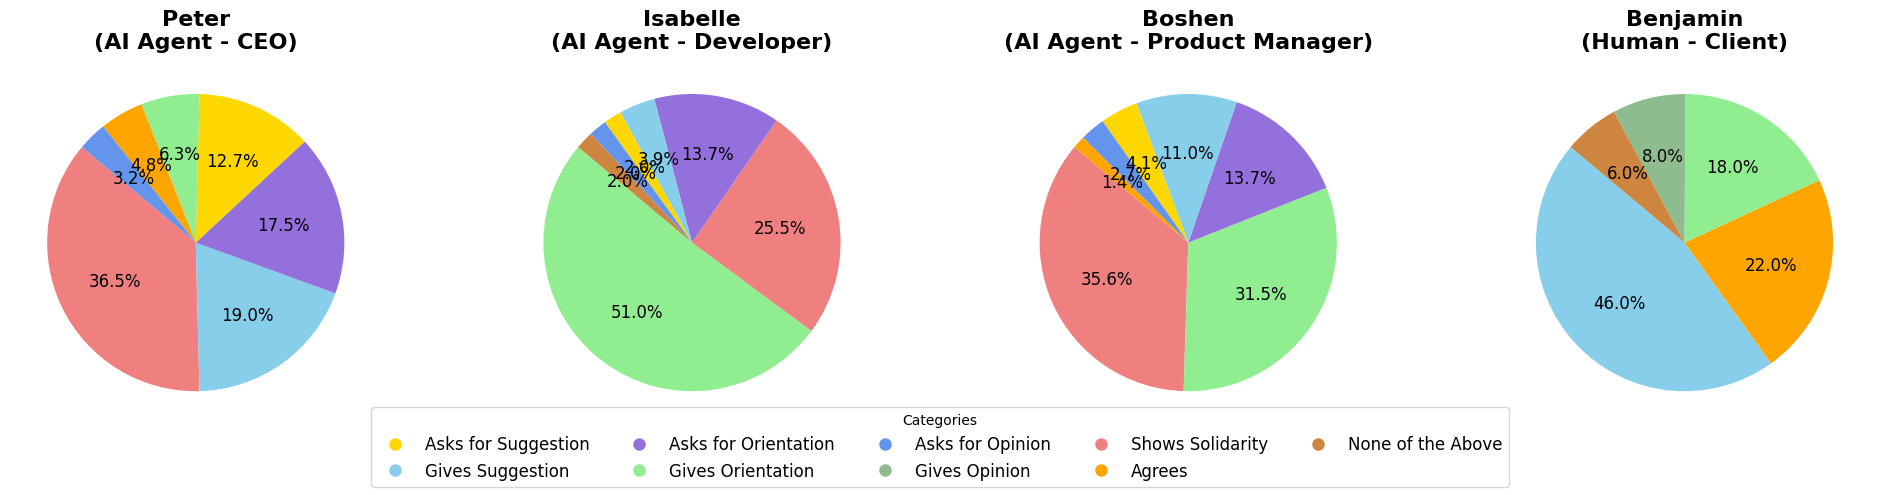

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set up directories
output_dir = get_output_dir()
viz_dir = os.path.join(output_dir, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# Load the data
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
data = pd.read_csv(file_path)

# Define color mappings
updated_color_palette = {
    "Asks for Suggestion": "gold",
    "Gives Suggestion": "skyblue",
    "Asks for Orientation": "mediumpurple",
    "Gives Orientation": "lightgreen",
    "Asks for Opinion": "cornflowerblue",
    "Gives Opinion": "darkseagreen",
    "Shows Solidarity": "lightcoral",
    "Agrees": "orange",
    "None of the Above": "peru",
}

# Update agents' titles
agent_titles = {
    "Benjamin": "Benjamin\n(Human - Client)",
    "Peter": "Peter\n(AI Agent - CEO)",
    "Boshen": "Boshen\n(AI Agent - Product Manager)",
    "Isabelle": "Isabelle\n(AI Agent - Developer)"
}

# Define ordered agents
ordered_agents = ["Peter", "Isabelle", "Boshen", "Benjamin"]

def plot_final_consolidated_pie_charts(column_name, title_prefix, color_map, agent_titles):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, agent in enumerate(ordered_agents):
        agent_data = data[data['name'] == agent][column_name].dropna()
        category_counts = agent_data.value_counts()

        colors = [color_map.get(category, "lightgrey") for category in category_counts.index]

        wedges, texts, autotexts = axes[i].pie(category_counts,
                                               autopct='%1.1f%%', 
                                               startangle=140, 
                                               colors=colors, 
                                               textprops={'fontsize': 12})
        
        for text in texts:
            text.set_fontsize(13)
        for autotext in autotexts:
            autotext.set_fontsize(12)
        
        axes[i].set_title(agent_titles[agent], fontsize=16, weight='bold')

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
               markersize=10, markerfacecolor=value) 
               for key, value in color_map.items()]
    fig.legend(handles=handles, loc='lower center', ncol=5, fontsize=12, title="Categories")

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Save the plot
    plt.savefig(
        os.path.join(viz_dir, "pie_charts.png"),
        dpi=300,
        bbox_inches='tight'
    )
    
    plt.show()

# Generate and save the plot
plot_final_consolidated_pie_charts('category', 'LLM', updated_color_palette, agent_titles)

### Heatmap

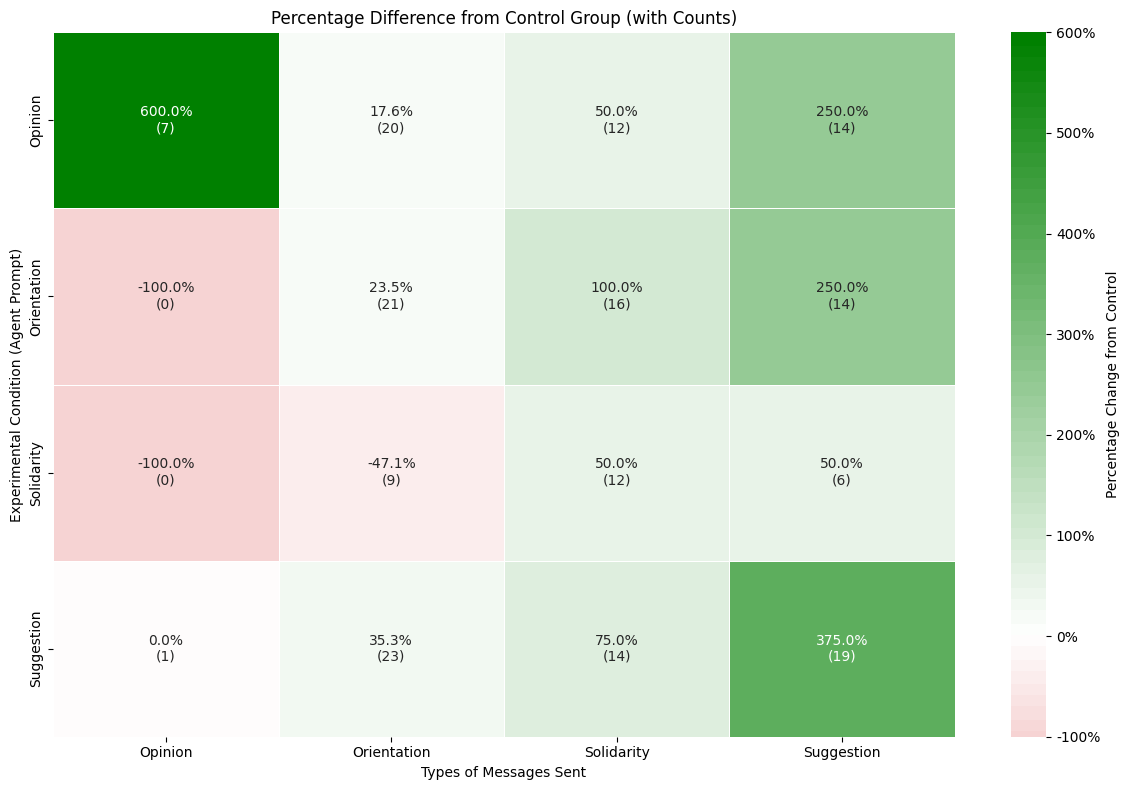

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# Step 1: Set up directories
output_dir = get_output_dir()
viz_dir = os.path.join(output_dir, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# Step 2: Load the data from the CSV file
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
data = pd.read_csv(file_path)

# Step 3: Calculate the raw count of each label in 'category' within each 'collapsed_experiment'
count_table = data.pivot_table(
    index='collapsed_experiment', 
    columns='collapsed_category', 
    aggfunc='size', 
    fill_value=0
)

# Step 4: Check if "Control" exists in 'collapsed_experiment' and isolate its counts
if 'Control' in count_table.index:
    control_counts = count_table.loc['Control']

    # Calculate the percentage change of counts versus the Control
    percent_change_from_control = count_table.apply(lambda x: (x - control_counts) / control_counts * 100, axis=1)

    # Remove the "Control" row for visualization purposes
    percent_change_no_control = percent_change_from_control.drop('Control', errors='ignore')

    # Filter out specific labels for the final visualization
    filtered_percent_change_conditions = percent_change_no_control.drop(
        columns=['Agrees', 'Error', 'None of the Above'], errors='ignore'
    )

    # Format both percentage changes and raw counts for annotations
    filtered_counts = count_table.drop('Control', errors='ignore')
    filtered_counts = filtered_counts.drop(
        columns=['Agrees', 'Error', 'None of the Above'], errors='ignore'
    )
    
    # Create combined annotations with percentages on top and counts in parentheses below
    filtered_combined_annotations = (
        filtered_percent_change_conditions.map(
            lambda x: f"{x:.1f}%" if pd.notnull(x) else ""
        ).astype(str) + '\n(' + filtered_counts.map(str) + ')'
    )

    # Get the actual min and max values for the scale
    vmin = filtered_percent_change_conditions.min().min()
    vmax = filtered_percent_change_conditions.max().max()
    
    # Round to the nearest 50 for cleaner bounds
    vmin = np.floor(vmin / 50) * 50
    vmax = np.ceil(vmax / 50) * 50
    
    # Create custom red to green colormap with darker green
    colors = [(0.8, 0, 0), (1, 1, 1), (0, 0.5, 0)]  # red, white, darker green
    n_bins = 100 
    custom_cmap = LinearSegmentedColormap.from_list("custom_RdGn", colors, N=n_bins)
    
    # Create the percentage change heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        filtered_percent_change_conditions, 
        annot=filtered_combined_annotations, fmt="", 
        cmap=custom_cmap,
        center=0,
        linewidths=0.5, 
        cbar_kws={
            'label': 'Percentage Change from Control',
            'format': '%.0f%%'
        },
        vmin=vmin, vmax=vmax,
        annot_kws={'va': 'center'}
    )

    # Formatting the heatmap
    plt.title('Percentage Difference from Control Group (with Counts)')
    plt.xlabel('Types of Messages Sent')
    plt.ylabel('Experimental Condition (Agent Prompt)')
    plt.tight_layout()

    # Save the plot in visualizations folder
    plt.savefig(
        os.path.join(viz_dir, "percentage_change_heatmap.png"), 
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

else:
    # If "Control" does not exist, show the raw count table
    print("Control group not found in the data. Displaying raw count table instead.")
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        count_table, 
        annot=True, fmt="d", cmap="RdYlGn", 
        linewidths=0.5, 
        cbar_kws={'label': 'Raw Counts'}
    )

    # Formatting the heatmap
    plt.title('Raw Counts of Labels by Experimental Condition')
    plt.xlabel('Label (collapsed_category)')
    plt.ylabel('Experimental Condition (collapsed_experiment)')
    plt.tight_layout()

    # Save the plot in visualizations folder
    plt.savefig(
        os.path.join(viz_dir, "raw_counts_heatmap.png"), 
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

### Clustered Bar Chart

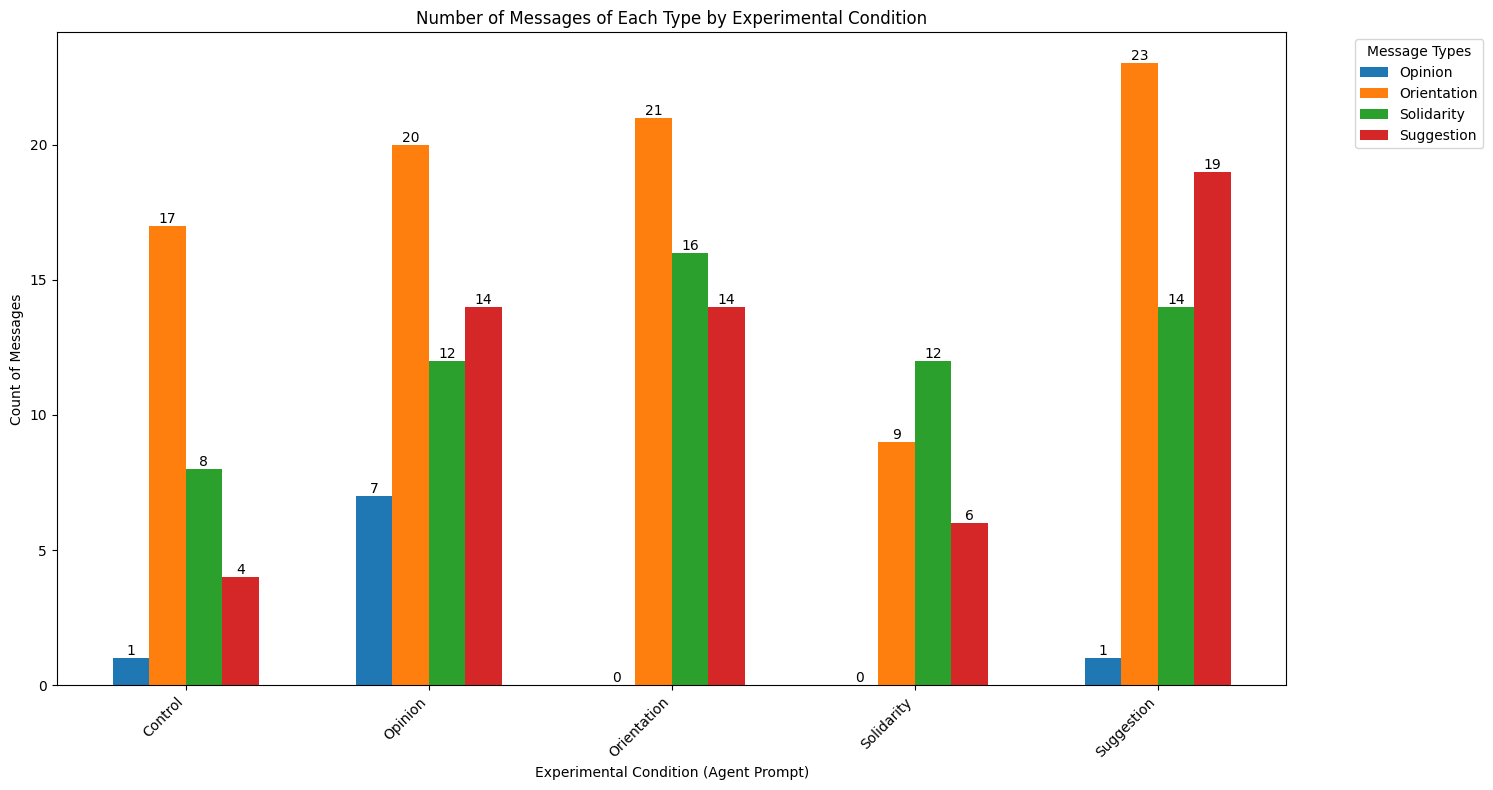

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 1: Create visualization directory
output_dir = get_output_dir()
viz_dir = os.path.join(output_dir, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# Step 2: Load the data
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
data = pd.read_csv(file_path)

# Step 3: Create pivot table
count_table = data.pivot_table(
    index='collapsed_experiment', 
    columns='collapsed_category', 
    aggfunc='size', 
    fill_value=0
)

# Filter categories
data_to_plot = count_table.drop(
    columns=['Agrees', 'Error', 'None of the Above'], 
    errors='ignore'
)

# Create plot
plt.figure(figsize=(15, 8))
x = np.arange(len(data_to_plot.index))
width = 0.15
n_columns = len(data_to_plot.columns)
total_width = width * n_columns

for idx, column in enumerate(data_to_plot.columns):
    offset = width * idx - (total_width/2) + (width/2)
    bars = plt.bar(x + offset, data_to_plot[column], width, label=column)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

# Customize plot
plt.xlabel('Experimental Condition (Agent Prompt)')
plt.ylabel('Count of Messages')
plt.title('Number of Messages of Each Type by Experimental Condition')
plt.xticks(x, data_to_plot.index, rotation=45, ha='right')
plt.legend(title='Message Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save in visualizations directory
plt.savefig(
    os.path.join(viz_dir, "grouped_barchart.png"), 
    dpi=300, 
    bbox_inches='tight'
)
plt.show()

### Interaction Sequences by Experimental Condition and Runs

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

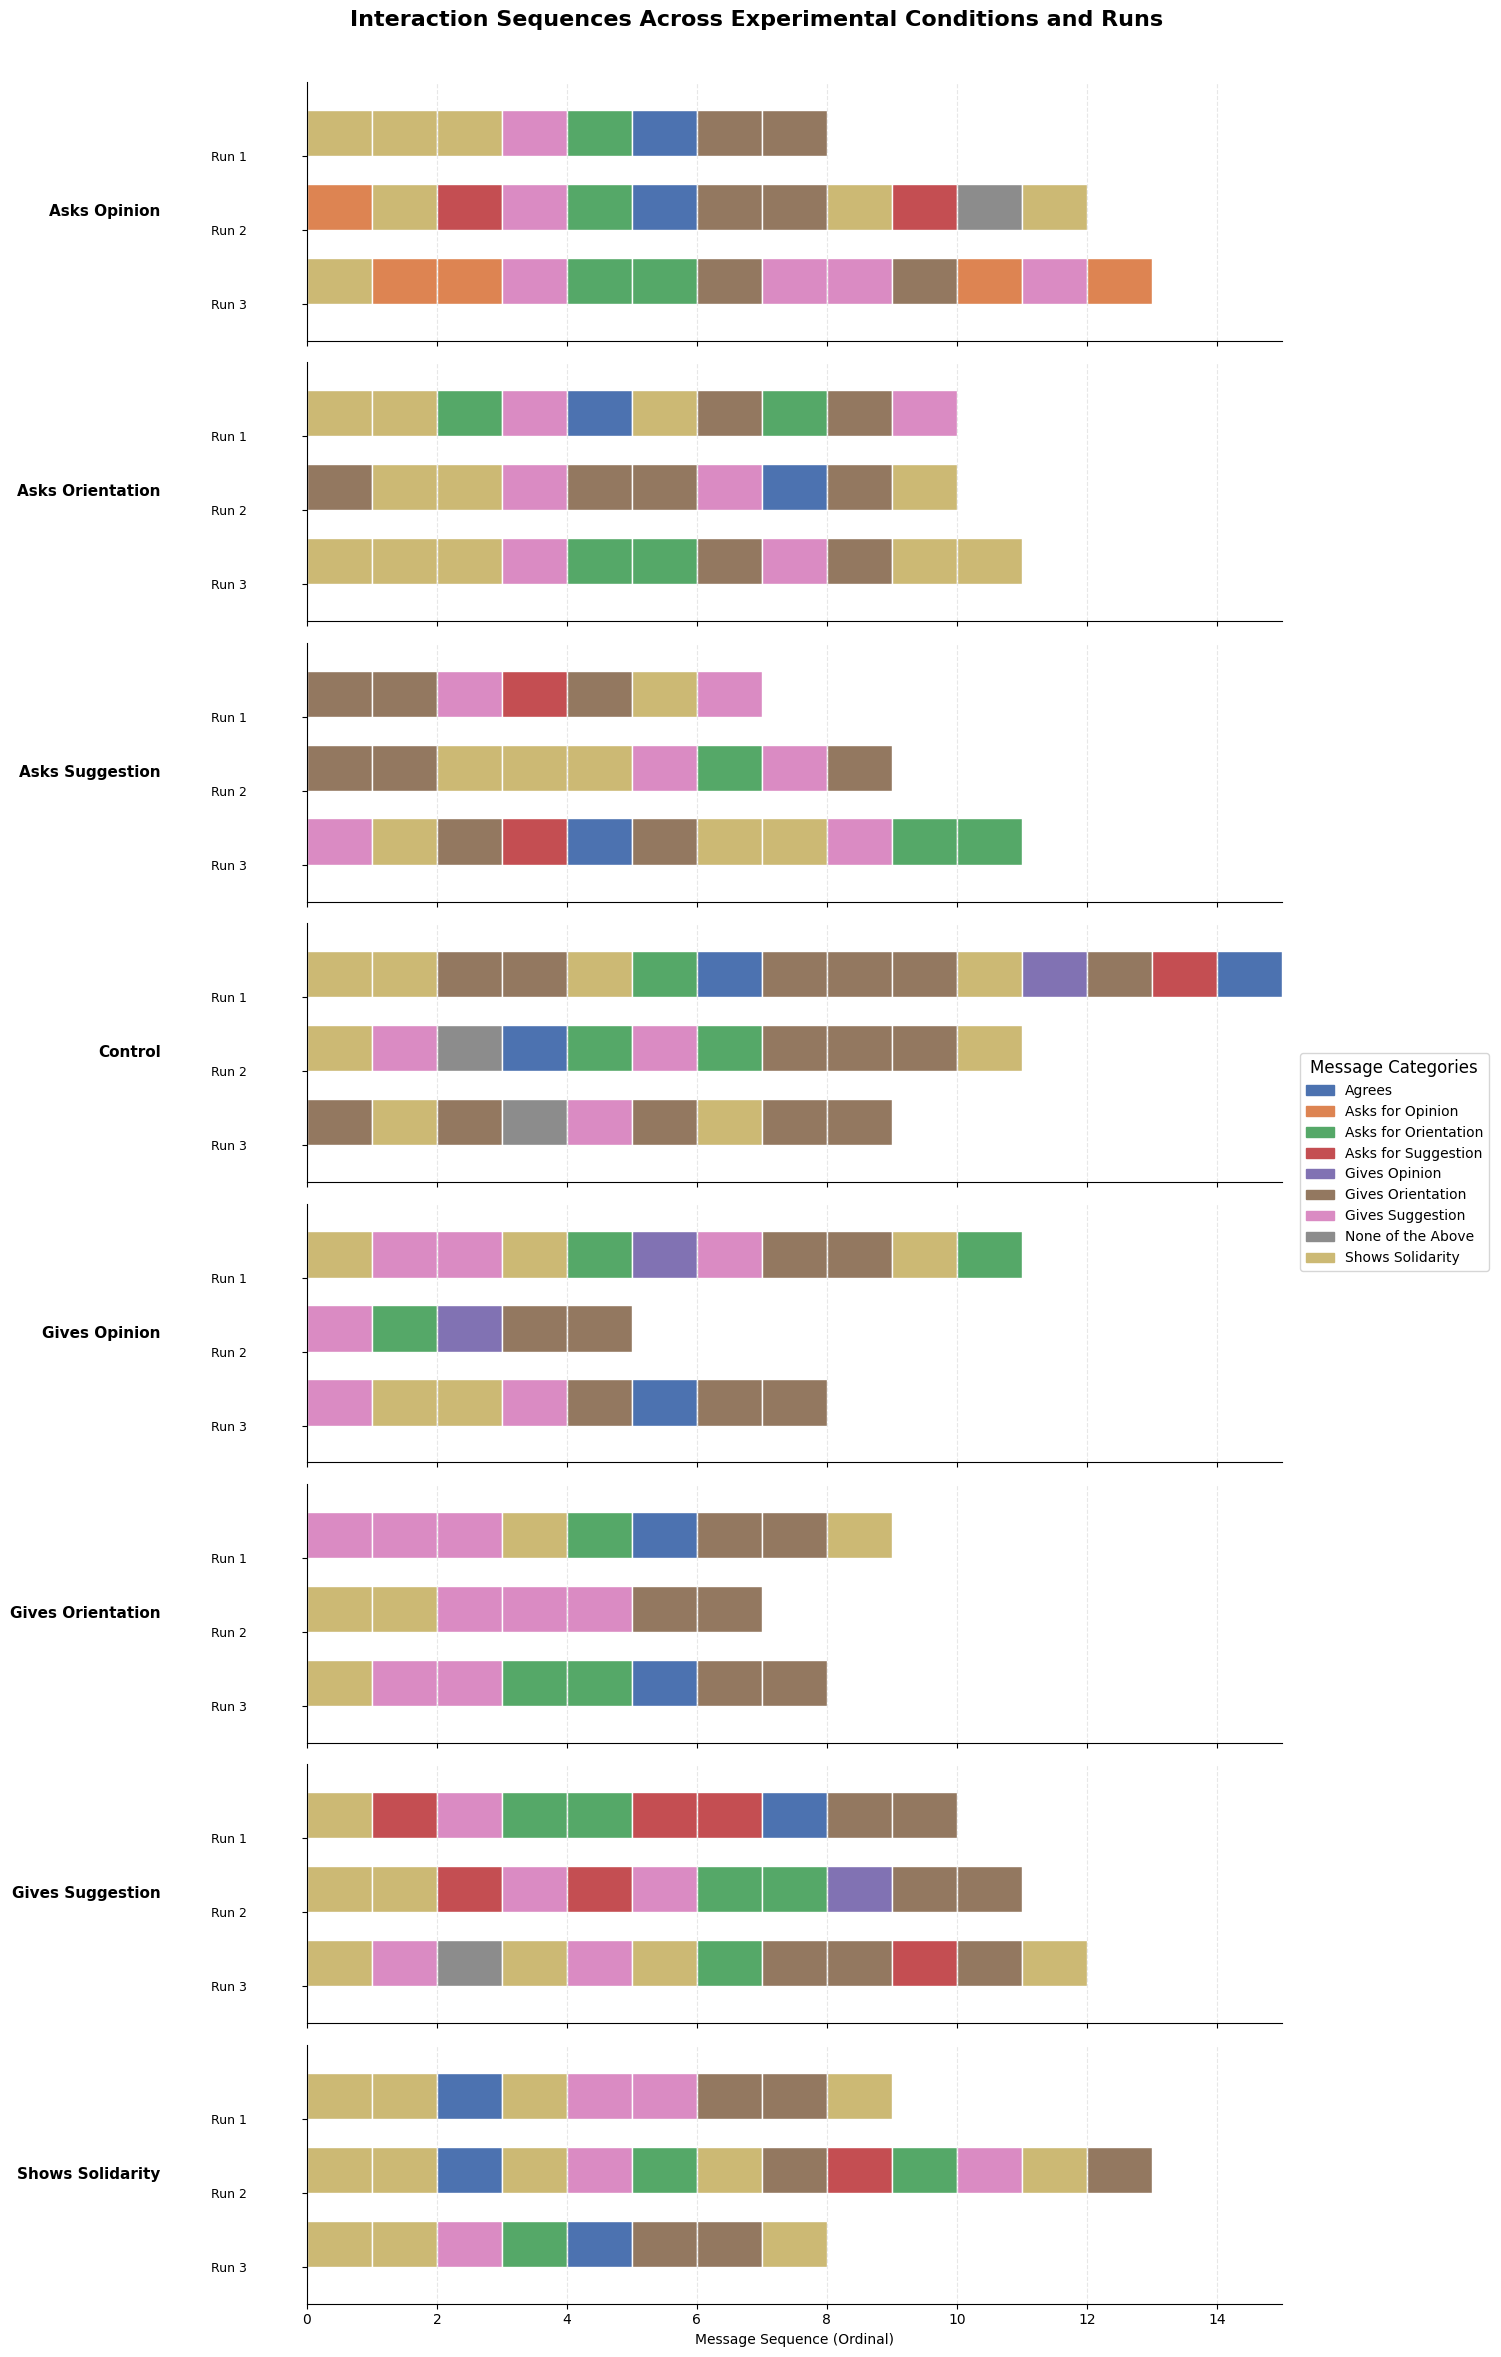

In [13]:
# Step 1: Load the data from the CSV file
output_dir = get_output_dir()
file_path = os.path.join(output_dir, 'analyzed_dialogues.csv')
data = pd.read_csv(file_path)

# Fix the datetime parsing warning by specifying format
data['datetime'] = pd.to_datetime('2023-01-01 ' + data['time_stamp'], 
                                 format='%Y-%m-%d %H:%M:%S', 
                                 errors='coerce')
data = data.sort_values(by='datetime').reset_index(drop=True)

# Get unique message categories from the data
unique_categories = sorted(data['category'].unique())

# Option 1: Using seaborn's color_palette
colors = sns.color_palette('deep', n_colors=len(unique_categories)).as_hex()
color_mapping = dict(zip(unique_categories, colors))

# Get conditions dynamically
ordered_conditions = sorted(data['experimental_condition'].unique())

# Find the maximum number of messages in any run
max_messages = data.groupby(['experimental_condition', 'run']).size().max()

# Define buffer to adjust spacing between rows and conditions
y_buffer = 0.8
condition_buffer = 3

# Create figure with custom layout using GridSpec
fig = plt.figure(figsize=(15, len(ordered_conditions) * 3))
gs = GridSpec(len(ordered_conditions) * condition_buffer, 1)

# Add a title to the entire figure
fig.suptitle('Interaction Sequences Across Experimental Conditions and Runs', 
             fontsize=16, fontweight='bold', y=0.98)

# Plot each experimental condition
for i, condition in enumerate(ordered_conditions):
    ax = fig.add_subplot(gs[i * condition_buffer:(i + 1) * condition_buffer, 0])
    condition_data = data[data['experimental_condition'] == condition]
    runs = sorted(condition_data['run'].unique())
    
    for j, run in enumerate(runs):
        run_data = condition_data[condition_data['run'] == run]
        y_position = (len(runs) - 1 - j) * y_buffer

        intervals = [(idx, 1) for idx in range(len(run_data))]
        colors = [color_mapping.get(row['category'], 'gray') for _, row in run_data.iterrows()]
        ax.broken_barh(intervals, (y_position, 0.5), facecolors=colors, edgecolors="white")

    # Create two-column layout for condition names and run labels
    ax.set_yticks([(len(runs) - 1 - y) * y_buffer for y in range(len(runs))])
    ax.set_yticklabels([f'Run {run}' for run in runs], fontsize=9)
    ax.tick_params(axis='y', pad=40)
    
    ax.set_ylim(-y_buffer/2, len(runs) * y_buffer)
    ax.set_xlim(0, max_messages)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add condition name with more padding and in a separate column
    ax.text(-0.15, 0.5, condition.replace('_', ' ').title(), 
            transform=ax.transAxes, ha='right', va='center', 
            fontsize=11, fontweight='bold')

    # Remove x-axis labels for all but the bottom subplot
    if i < len(ordered_conditions) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Message Sequence (Ordinal)', fontsize=10)

# Adjust layout with more space on the left
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85, top=0.95, hspace=0.3)

# Create legend in separate axes on the right side
legend_ax = fig.add_axes([0.86, 0.2, 0.13, 0.6])
patches_legend = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
legend = legend_ax.legend(handles=patches_legend, loc='center', title="Message Categories", 
                         title_fontsize=12, fontsize=10, frameon=True)
legend_ax.axis('off')

plt.show()